# Sparsity Assessment of DMAE

In this notebook we'll assess the behavior of DMAE to different values of the softmax inverse temperature parameter $\alpha$.

In [1]:
# Required libraries
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import colors
plt.style.use("ggplot")
%matplotlib inline

# remove warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 
import logging
logging.getLogger('tensorflow').disabled = True

# Path of the DMAE library
import sys
# sys.path.append("/tf/home/repositorios/DMAE/") # how to use the code in other location
sys.path.append("../../")
import DMAE

# Dataset
from sklearn.datasets import load_digits

# Setting random seed
np.random.seed(0)
tf.random.set_seed(0)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# Imporing some helper functions to visualize and understand the results
import vis_utils

We define some hyperparameters:

In [2]:
# Number of prototype vectors
n_clusters = 10
# Pretrain parameters
pretrain_batch = 256
pretrain_epochs = 500
pretrain_params = {"lr": 1.0, "momentum":0.9}
# Cluster parameters
cluster_batch = 599
cluster_epochs = 30
cluster_params = {"lr": 1e-5}
# Loss weights
lambda_r = 0.01
lambda_c = 1.0

trials = 5

In this case, we're going to use UCI ML hand-written digits dataset:

In [3]:
data = load_digits()
X, y = data["data"], data["target"]
X = X/16.0

First, we're going to define some function to create the models:

In [4]:
def make_autoencoder(train=False):
    act = "relu"
    init = tf.keras.initializers.VarianceScaling(scale=1./3., mode='fan_in', distribution='uniform')
    encoder = tf.keras.models.Sequential([tf.keras.layers.Dense(256, activation=act, input_shape=(64,), kernel_initializer=init),
                                          tf.keras.layers.Dense(256, activation=act, kernel_initializer=init),
                                          tf.keras.layers.Dense(10, activation="linear", kernel_initializer=init)])
    decoder = tf.keras.models.Sequential([tf.keras.layers.Dense(256, activation=act, input_shape=(10,), kernel_initializer=init),
                                          tf.keras.layers.Dense(256, activation=act, kernel_initializer=init),
                                          tf.keras.layers.Dense(64, activation="linear", kernel_initializer=init)])
    inp = tf.keras.layers.Input(shape=(64, ))
    out = decoder(encoder(inp))
    autoencoder = tf.keras.Model(inputs=inp, outputs=out)
    autoencoder.compile(loss="mse", optimizer=tf.optimizers.SGD(**pretrain_params))
    if train:
        autoencoder.fit(X, X, epochs=pretrain_epochs, batch_size=pretrain_batch, verbose=False)
    return encoder, decoder, autoencoder

In [5]:
def make_dmae(encoder, decoder, al, pretrainer):
    inp = tf.keras.layers.Input(shape=(64, ))
    h = encoder(inp)
    theta_tilde = DMAE.Layers.DissimilarityMixtureAutoencoderCov(al, n_clusters, batch_size=cluster_batch,
                                                                 initializers={"centers": DMAE.Initializers.InitKMeans(pretrainer),
                                                                               "cov": DMAE.Initializers.InitKMeansCov(pretrainer, X_latent, n_clusters),
                                                                               "mixers": tf.keras.initializers.Constant(1.0)},
                                                                 trainable = {"centers": True, "cov":True, "mixers":True},
                                                                 dissimilarity=dis, grad_modifier=1)(h)
    x_tilde = decoder(theta_tilde[0])
    # defining keras model
    full_model = tf.keras.Model(inputs=[inp], outputs=x_tilde)
    loss1 = dmae_loss(h, *theta_tilde)
    loss2 = tf.losses.mse(inp, x_tilde)
    loss = lambda_c*loss1+lambda_r*loss2
    full_model.add_loss(loss)
    full_model.compile(optimizer=tf.optimizers.Adam(**cluster_params))
    full_model.fit(X, epochs=cluster_epochs, batch_size=cluster_batch, verbose=False)
    return full_model

In [6]:
def make_dm_encoder(encoder, al, full_model):
    inp = tf.keras.layers.Input(shape=(64,))
    h = encoder(inp)
    assigns = DMAE.Layers.DissimilarityMixtureEncoderCov(al, n_clusters=n_clusters,
                                                         dissimilarity=dis, batch_size=cluster_batch,
                                                         trainable={"centers":False, "cov":False, "mixers":False})(h)
    full_encoder = tf.keras.Model(inputs=[inp], outputs=[assigns])
    full_encoder.layers[-1].set_weights(full_model.layers[2].get_weights())
    return full_encoder

We'll solve this problem using the Mahalanobis distance (includes the covariances):

In [7]:
dis = DMAE.Dissimilarities.mahalanobis
dmae_loss = DMAE.Losses.mahalanobis_loss
dis_name = "Mahalanobis"

First, we pretrain the autoencoders:

In [8]:
acc_kmeans = []
for trial in range(trials):
    encoder, decoder, autoencoder = make_autoencoder(True)
    autoencoder.save_weights(f"ae_{trial}.h5")
    # Train KMeans to pretrain DMAE
    X_latent = encoder.predict(X)
    pretrainer = KMeans(10).fit(X_latent)
    preds = pretrainer.predict(X_latent)
    # Evaluate AE+KMeans
    acc_kmeans.append(DMAE.Metrics.unsupervised_classification_accuracy(y, preds))

Now, DMAE is trained:

In [9]:
alpha = np.logspace(0, 4, 15)
acc_dmae = []
for i, al in enumerate(alpha):
    print(f"{i+1}/{alpha.size}")
    cur_kmeans = []; cur_dmae= []
    for trial in range(trials):
        # make autoencoder
        encoder, decoder, autoencoder = make_autoencoder()
        autoencoder.load_weights(f"ae_{trial}.h5")
        X_latent = encoder.predict(X)
        pretrainer = KMeans(10).fit(X_latent)
        # Make full model
        full_model = make_dmae(encoder, decoder, al, pretrainer)
        full_encoder = make_dm_encoder(encoder, al, full_model)
        # Evaluate the full model
        assigns = full_encoder.predict(X, batch_size=cluster_batch)
        y_pred = np.argmax(assigns, axis=1)
        cur_dmae.append(DMAE.Metrics.unsupervised_classification_accuracy(y, y_pred))
    acc_dmae.append((np.mean(cur_dmae), np.std(cur_dmae)))

1/15
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/15
3/15
4/15
5/15
6/15
7/15
8/15
9/15
10/15
11/15
12/15
13/15
14/15
15/15


In [10]:
acc_kmeans = np.array(acc_kmeans)
acc_dmae = np.array(acc_dmae)

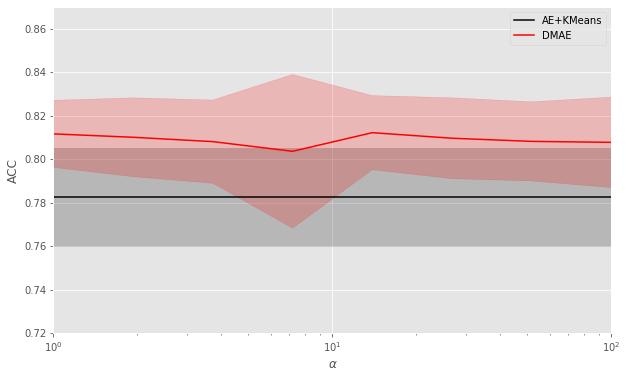

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
kmeans_mean = np.ones_like(alpha)*acc_kmeans.mean()
kmeans_std = acc_kmeans.std()
ax.semilogx(alpha, kmeans_mean, c="k", label="AE+KMeans")
ax.fill_between(alpha, kmeans_mean+kmeans_std, kmeans_mean-kmeans_std, alpha=0.2, color="k")
ax.semilogx(alpha, acc_dmae[:, 0], c="r", label="DMAE")
ax.fill_between(alpha, acc_dmae[:,0]+acc_dmae[:,1], acc_dmae[:,0]-acc_dmae[:,1], alpha=0.2, color="r")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("ACC")
ax.set_xlim([1, 100])
ax.set_ylim([0.72, 0.87])
ax.legend()